<a href="https://colab.research.google.com/github/wander-asb/Customer_Segmentation/blob/main/Segmenta%C3%A7%C3%A3o_de_consumidores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

In [161]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


from google.colab                import drive
import warnings
warnings.filterwarnings("ignore")

In [162]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [163]:
df_segmentacao = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Segmentação de Clientes/online_retail_II.xlsx')
df_segmentacao.shape

(525461, 8)

In [164]:
df_segmentacao.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [165]:
df_segmentacao.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [166]:
df_segmentacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## Tratamento de dados

In [167]:
#Retiramos dados nulos de consumidores
df_segmentacao = df_segmentacao[~df_segmentacao['Customer ID'].isna()].drop('Description', axis=1)

In [168]:
#Verificamos que existem quantidades negativas de compras
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 0]

In [169]:
#Intervalo de tempo da base de dados
df_segmentacao['InvoiceDate'].agg(['min', 'max'])

#A data máxima será a medida final do intervalo de recencia
data_máxima = max(df_segmentacao['InvoiceDate'])

In [170]:
#Excluir linhas com comportamento de quantidade de compra negativa, pode ser estorno
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 0]

In [171]:
data_máxima

Timestamp('2010-12-09 20:01:00')

In [172]:
df_segmentacao['Customer ID'] = df_segmentacao['Customer ID'].astype(int).astype(str)
df_segmentacao.shape

(407695, 7)

In [173]:
#Quantidade de clientes únicos pertencentes a base de dados
len(df_segmentacao['Customer ID'].unique().tolist())

4314

In [174]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [175]:
#Criar análise de RFM para a base de clientes
df_segmentacao['Amount'] = df_segmentacao['Price'] * df_segmentacao['Quantity']

## RFM Analytcs

### Montante 

In [176]:
#Cria feature de montante transacionado
df_monetary = df_segmentacao.groupby('Customer ID')['Amount'].sum().reset_index().rename({'Amount':'Montante'}, axis = 1)

### Frequencia

In [177]:
#Cria feature de invoice consumida
df_frequency = df_segmentacao.groupby('Customer ID')['Invoice'].count().reset_index().rename({'Invoice':'Frequencia'}, axis = 1)

In [178]:
#Junta as features criadas logo acima
rfm_dataframe = df_monetary.merge(df_frequency, on='Customer ID')

### Recencia

In [179]:
#Trazer feature de recência de cada consumidor
df_segmentacao['Recencia'] = data_máxima - df_segmentacao['InvoiceDate']

#Buscamos a data mínima em dias de cada cliente
df_recency = df_segmentacao.groupby('Customer ID')['Recencia'].min().reset_index()

#Tratamos a data
df_recency['Recencia'] = df_recency['Recencia'].dt.days

#Junta as features tratadas
rfm_dataframe = rfm_dataframe.merge(df_recency, on='Customer ID')

### Elasticidade

In [180]:
#Buscamos a data em dias da última compra do cliente
data_ultima_compra = df_segmentacao.groupby('Customer ID')['InvoiceDate'].max().reset_index()

#Renomeamos a coluna de InvoiceDate para "Data ultima compra"
data_ultima_compra = data_ultima_compra.rename(columns={'InvoiceDate':'Data ultima compra'})

In [181]:
#Buscamos a data em dias da primeira compra do cliente
data_primeira_compra = df_segmentacao.groupby('Customer ID')['InvoiceDate'].min().reset_index()

#Renomeamos a coluna de InvoiceDate para "Data ultima compra"
data_primeira_compra = data_primeira_compra.rename(columns={'InvoiceDate':'Data primeira compra'})

In [182]:
elasticidade = data_ultima_compra.merge(data_primeira_compra, on='Customer ID', how='left')

In [183]:
#Calculamos a feature de comprimento (elasticidade)
elasticidade['Elasticidade'] = elasticidade['Data ultima compra'] - elasticidade['Data primeira compra']

In [184]:
#Tratamos a data
elasticidade['Elasticidade'] = elasticidade['Elasticidade'].dt.days

In [185]:
#Junta as features tratadas
rfm_dataframe = rfm_dataframe.merge(elasticidade[['Customer ID','Elasticidade']], on='Customer ID')

# ATUALIZAR TABELA NO OVERLEAF DE PRIMEIROS CINCO AMOSTRAS E RFM DESCRIBE

## Tabela de RFM+E

In [186]:
#Iremos calcular o indicador de lifetime value de cada cliente
#df_ticket = df_segmentacao.groupby('Customer ID')['Amount'].mean().reset_index().rename({'Amount':'Ticket_medio'}, axis =1)

#Adicionamos a feature de ticket médio no dataframe da análise RFM
#rfm_dataframe = rfm_dataframe.merge(df_ticket, on='Customer ID')

In [187]:
#Para calcularmpos a rentenção do cliente, iremos calcular a quantidade de meses que ele esteva tivo na nossa empresa, isto é, a quantidade de meses que ele realizou ao menos uma compra
#df_segmentacao['Safra'] = df_segmentacao['InvoiceDate'].dt.to_period('M')
#df_rentecao = df_segmentacao.groupby('Customer ID')['Safra'].nunique().reset_index().rename({'Safra':'Retencao'}, axis =1)

#Adicionamos a feature de retenção no dataframe da análise RFM
#rfm_dataframe = rfm_dataframe.merge(df_rentecao, on='Customer ID')

In [188]:
#Por conseguinte, temos todas os atributos para calcularmos o life time value
#rfm_dataframe['LTV'] = rfm_dataframe['Frequencia'] * rfm_dataframe['Retencao'] * rfm_dataframe['Ticket_medio']

In [189]:
rfm_dataframe.head()

,Customer ID,Montante,Frequencia,Recencia,Elasticidade
0,12346,372.86,33,164,196
1,12347,1323.32,71,2,37
2,12348,222.16,20,73,0
3,12349,2671.14,102,42,181
4,12351,300.93,21,10,0


## Remoção de outliers

In [190]:
rfm_dataframe.describe().round(2)

,Montante,Frequencia,Recencia,Elasticidade
count,4314.00,4314.00,4314.00,4314.00
mean,2047.29,94.51,90.27,133.94
std,8912.52,202.02,96.94,132.83
min,0.00,1.00,0.00,0.00
25%,307.95,18.00,17.00,0.00
50%,705.55,44.00,52.00,105.00
75%,1722.80,102.00,135.00,253.75
max,349164.35,5570.00,373.00,373.00


In [191]:
# Remoção de outliers
Q1 = rfm_dataframe.Montante.quantile(0.05)
Q3 = rfm_dataframe.Montante.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Montante >= Q1 - 1.5*IQR) & (rfm_dataframe.Montante <= Q3 + 1.5*IQR)]

Q1 = rfm_dataframe.Recencia.quantile(0.05)
Q3 = rfm_dataframe.Recencia.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Recencia >= Q1 - 1.5*IQR) & (rfm_dataframe.Recencia <= Q3 + 1.5*IQR)]

Q1 = rfm_dataframe.Frequencia.quantile(0.05)
Q3 = rfm_dataframe.Frequencia.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Frequencia >= Q1 - 1.5*IQR) & (rfm_dataframe.Frequencia <= Q3 + 1.5*IQR)]

Q1 = rfm_dataframe.Elasticidade.quantile(0.05)
Q3 = rfm_dataframe.Elasticidade.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Elasticidade >= Q1 - 1.5*IQR) & (rfm_dataframe.Elasticidade <= Q3 + 1.5*IQR)]

In [192]:
len(rfm_dataframe['Customer ID'].unique().tolist())

4231

In [193]:
rfm_dataframe[rfm_dataframe['Montante'] < 0]

,Customer ID,Montante,Frequencia,Recencia,Elasticidade


## Desenvolvimento

### Normalização de dados

In [194]:
#Normalização de dados
normalizacao = StandardScaler()

df_rfm = rfm_dataframe[['Montante','Recencia','Frequencia','Elasticidade']]
rfm = normalizacao.fit_transform(df_rfm)
rfm

array([[-0.53046259,  0.74435901, -0.45948714,  0.50259171],
       [-0.02410302, -0.9225964 , -0.08073981, -0.7116107 ],
       [-0.61074833, -0.19201718, -0.58905859, -0.99416094],
       ...,
       [-0.50161939,  2.09232912, -0.66879487, -0.99416094],
       [-0.03842872,  0.19899705, -0.12060795,  0.89205286],
       [ 0.52057741, -0.76824867,  0.05879867,  0.44149976]])

### Ellow Method

Número de grupos = 2 Coef. de Silhouette = 0.3986
Número de grupos = 3 Coef. de Silhouette = 0.3831
Número de grupos = 4 Coef. de Silhouette = 0.4131
Número de grupos = 5 Coef. de Silhouette = 0.4054
Número de grupos = 6 Coef. de Silhouette = 0.4086
Número de grupos = 7 Coef. de Silhouette = 0.3714
Número de grupos = 8 Coef. de Silhouette = 0.3416
Número de grupos = 9 Coef. de Silhouette = 0.3457


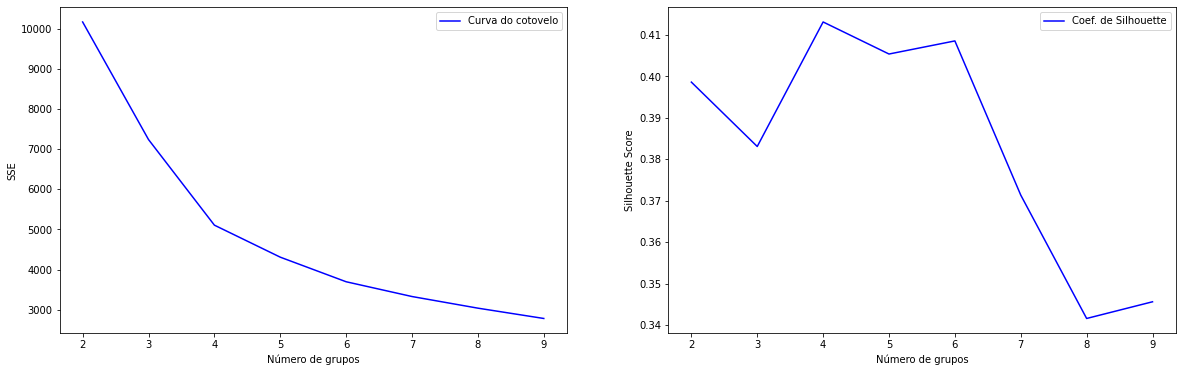

In [195]:
range_n_clusters = [i for i in range(2,10)]
elbow = []
ss = []
for n_clusters in range_n_clusters:
   clusterer = KMeans(n_clusters = n_clusters, random_state=42, init='k-means++')
   cluster_labels = clusterer.fit_predict(rfm)
   silhouette_avg = silhouette_score(rfm, cluster_labels)
   ss.append(silhouette_avg)
   print("Número de grupos =", n_clusters,"Coef. de Silhouette =", round(silhouette_avg, 4))
   elbow.append(clusterer.inertia_) 


fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Curva do cotovelo')
plt.xlabel("Número de grupos")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Coef. de Silhouette')
plt.xlabel("Número de grupos")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3990350425370056
For n_clusters = 3 The average silhouette_score is : 0.3685423872055454
For n_clusters = 4 The average silhouette_score is : 0.4131382153480577
For n_clusters = 5 The average silhouette_score is : 0.4155739974979986
For n_clusters = 6 The average silhouette_score is : 0.40925719039673014


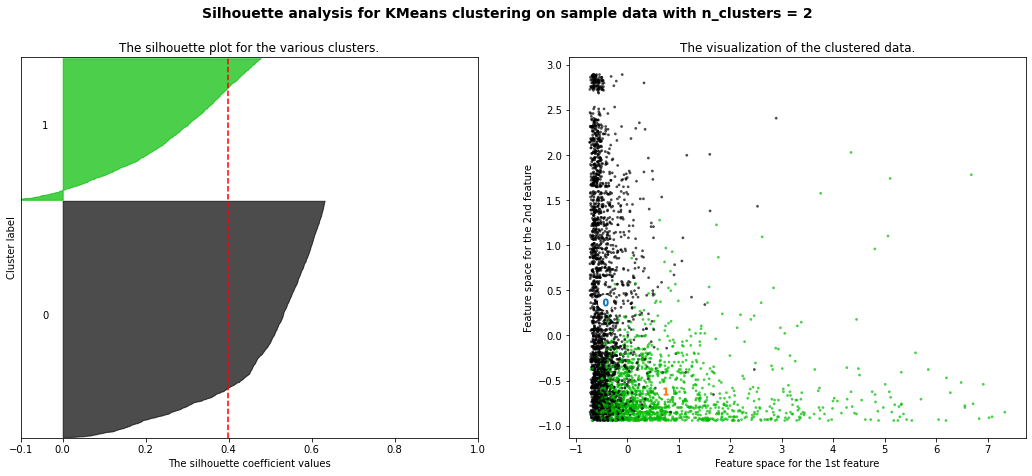

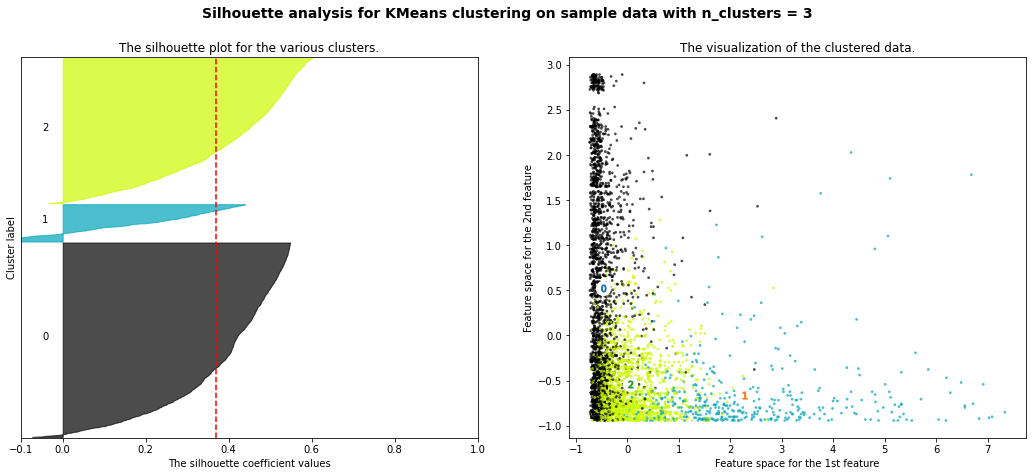

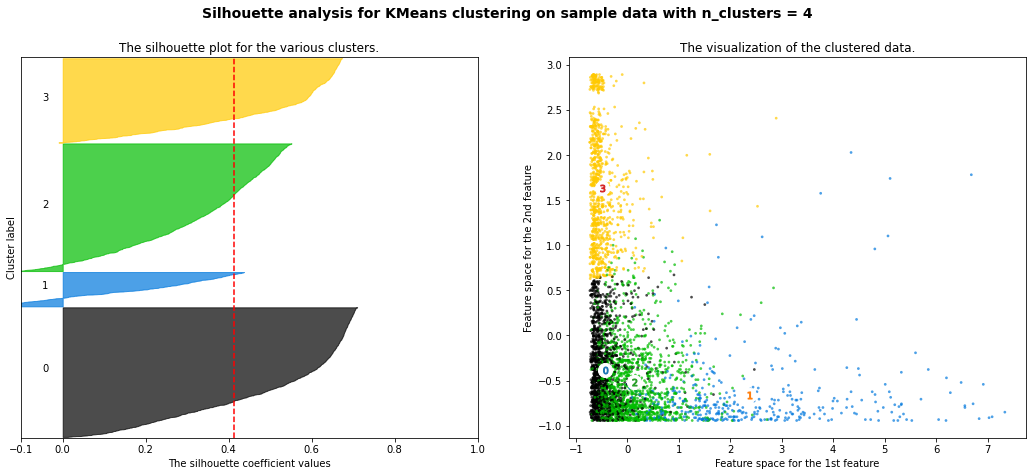

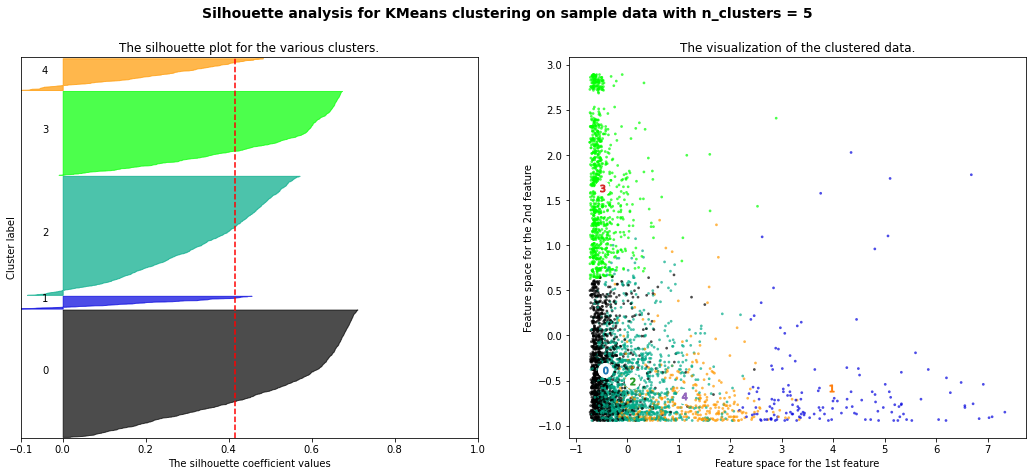

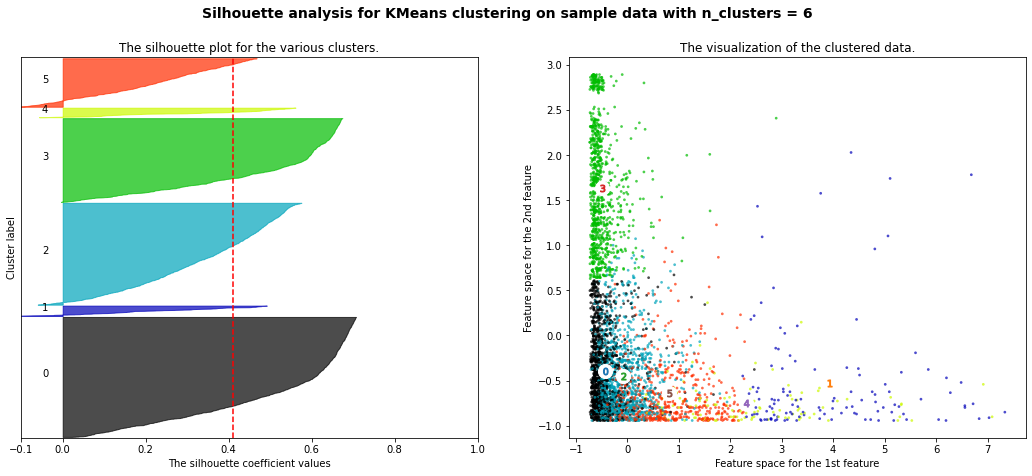

In [196]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = rfm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k", cmap="RdBu"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        #edgecolor="k",
        cmap="RdBu",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0],
                    c[1],
                    marker="$%d$" % i,
                    alpha=1, s=50,
                    #edgecolor="k",
                    cmap="RdBu")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [197]:
model = KMeans(n_clusters = 4, random_state=42, init='k-means++')
cluster_labels = model.fit_predict(rfm)

In [198]:
rfm_dataframe['Segmentacao'] = cluster_labels + 1

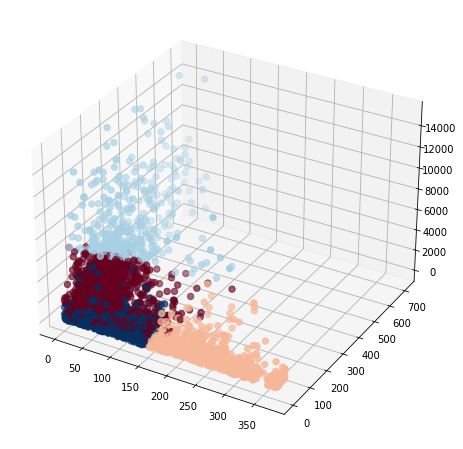

In [199]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfm_dataframe['Recencia'])
y = np.array(rfm_dataframe['Frequencia'])
z = np.array(rfm_dataframe['Montante'])
w = np.array(rfm_dataframe['Elasticidade'])

ax.scatter(x, y, z, w, c=rfm_dataframe["Segmentacao"], s=40, cmap="RdBu")

plt.show()

In [200]:
tabela_segmentacao = rfm_dataframe[['Segmentacao','Montante','Recencia','Frequencia','Elasticidade']].groupby('Segmentacao').agg(['mean','count','min','max']).round()

In [201]:
tabela_segmentacao

Montante                        Recencia                  \
                mean count     min      max     mean count  min  max   
Segmentacao                                                            
1             1606.0  1437    43.0   6702.0     42.0  1437    0  216   
2              448.0   948     0.0   6799.0    251.0   948  153  373   
3             5791.0   387  1353.0  15139.0     28.0   387    0  289   
4              560.0  1459     4.0   6001.0     55.0  1459    0  157   

            Frequencia                Elasticidade                 
                  mean count min  max         mean count min  max  
Segmentacao                                                        
1                 96.0  1437   2  349        254.0  1437  40  373  
2                 27.0   948   1  259         24.0   948   0  196  
3                304.0   387   1  712        296.0   387   0  373  
4                 36.0  1459   1  287         33.0  1459   0  188

## Análise de grupos

O que podemos analisar é que possuímos três grupos de clientes muito ativos financeiramente na nossa empresa, respectivamente, temos o grupo 9, que apresenta a maior média transacionada, segunda maior frequência e maior custo de vida no nosso estabelecimento. Em contraste a ele, porém com comportamentos parecidos, são os consumidores pertencentes aos grupos 8 e 5, no qual são definidos por uma recência praticamente equivalente, seguidos por colocações de segundo e terceiro lugar com maior média de montante transacionado. 

Iremos denominar eles como:
* Grupo 9: Campeões
* Grupo 8: Fieis 
* Grupo 7: Casuais Campeões

Outro grupo com característica interessante, é o grupo 2, possui compras recentes, são clientes que possuem uma carteira alta, apresentam um comportamento de compra não tão frequente, podemos considerar eles como novos clientes.

Iremos denominar eles como:
* Grupo 9: Campeões
* Grupo 8: Fieis 
* Grupo 7: Casuais Campeões
* Grupo 2: Novos clientes

Agora, precisamos encontrar aqueles clientes pontuais, que denominaremos como clientes casuais, são clientes que apresentam uma frequencia e recência de compras próxima, aqui, não iremos olhar montante e custo de vida.

Iremos denominar eles como:
* Grupo 9: Campeões
* Grupo 8: Fieis 
* Grupo 7: Casuais Campeões
* Grupo 2: Novos clientes
* Grupo 5 e 4: Casuais
* Grupo 1, 3 e 6: Sumidos

In [ ]:
df_model['Grupos'] = df_model['Segmentacao'].replace({1:'Sumidos',
                                           3:'Sumidos',
                                           6:'Sumidos',
                                           5:'Casuais',
                                           4:'Casuais',
                                           2:'Novos clientes',
                                           7:'Casuais campeões',
                                           8:'Fieis',
                                           9:'Campões'})


df_model['Grupos_num'] = df_model['Segmentacao'].replace({1:1,
                                           3:1,
                                           6:1,
                                           5:2,
                                           4:2,
                                           2:3,
                                           7:4,
                                           8:5,
                                           9:6})

In [ ]:
df_model['Grupos'].head()

0    Casuais campeões
1      Novos clientes
2    Casuais campeões
3             Casuais
4      Novos clientes
Name: Grupos, dtype: object

In [ ]:
df_model[['Grupos','Montante','Recencia','Frequencia','LTV']].groupby('Grupos').agg(['mean','count','max']).round()

Montante                Recencia            Frequencia        \
                     mean count      max     mean count  max       mean count   
Grupos                                                                          
Campões           10030.0    56  14646.0     12.0    56   57      364.0    56   
Casuais            3081.0   730  13125.0     25.0   730  136      179.0   730   
Casuais campeões    775.0   921   4067.0     75.0   921  116       42.0   921   
Fieis              4045.0   114   8377.0     22.0   114  186      467.0   114   
Novos clientes      825.0  1266   5169.0     21.0  1266   49       46.0  1266   
Sumidos             494.0  1190  10877.0    231.0  1190  373       30.0  1190   

                            LTV                  
                  max      mean count       max  
Grupos                                           
Campões           688  102800.0    56  175749.0  
Casuais           349   19342.0   730  103320.0  
Casuais campeões  186    2338.0   921   29777.0  
Fieis             715   31395.0   114   78978.0  
Novos clientes    131    2780.0  1266   28214.0  
Sumidos           268    1144.0  1190   37643.0

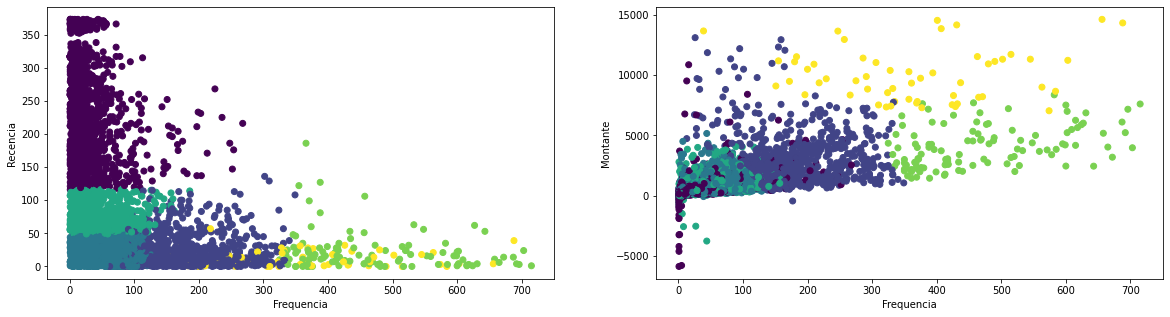

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = df_model['Frequencia'], y = df_model['Recencia'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Recencia')

ax = fig.add_subplot(122)
plt.scatter(x = df_model['Frequencia'], y = df_model['Montante'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Montante')
plt.show()

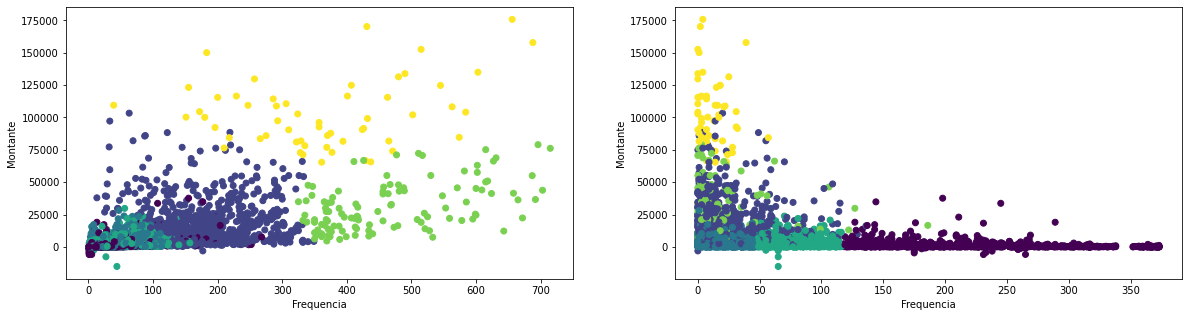

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = df_model['Frequencia'], y = df_model['LTV'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Montante')

ax = fig.add_subplot(122)
plt.scatter(x = df_model['Recencia'], y = df_model['LTV'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Montante')
plt.show()